# 导包

In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

# 数据预处理

In [2]:
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = [
        # enc_input           dec_input         dec_output
        ['ich mochte ein bier P', 'S i want a beer .', 'i want a beer . E'],
        ['ich mochte ein cola P', 'S i want a coke .', 'i want a coke . E']
]

# Padding Should be Zero
src_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'bier' : 4, 'cola' : 5}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'coke' : 5, 'S' : 6, 'E' : 7, '.' : 8}
idx2word = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 5 # enc_input max sequence length
tgt_len = 6 # dec_input(=dec_output) max sequence length

def make_data(sentences):
    enc_inputs, dec_inputs, dec_outputs = [], [], []
    for i in range(len(sentences)):
      enc_input = [[src_vocab[n] for n in sentences[i][0].split()]] # [[1, 2, 3, 4, 0], [1, 2, 3, 5, 0]]
      dec_input = [[tgt_vocab[n] for n in sentences[i][1].split()]] # [[6, 1, 2, 3, 4, 8], [6, 1, 2, 3, 5, 8]]
      dec_output = [[tgt_vocab[n] for n in sentences[i][2].split()]] # [[1, 2, 3, 4, 8, 7], [1, 2, 3, 5, 8, 7]]

      enc_inputs.extend(enc_input)
      dec_inputs.extend(dec_input)
      dec_outputs.extend(dec_output)

    return torch.LongTensor(enc_inputs), torch.LongTensor(dec_inputs), torch.LongTensor(dec_outputs)

enc_inputs, dec_inputs, dec_outputs = make_data(sentences)

class MyDataSet(Data.Dataset):
  def __init__(self, enc_inputs, dec_inputs, dec_outputs):
    super(MyDataSet, self).__init__()
    self.enc_inputs = enc_inputs
    self.dec_inputs = dec_inputs
    self.dec_outputs = dec_outputs
  
  def __len__(self):
    return self.enc_inputs.shape[0]
  
  def __getitem__(self, idx):
    return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]

loader = Data.DataLoader(MyDataSet(enc_inputs, dec_inputs, dec_outputs), 2, True)

# 模型参数
下面变量代表的含义依次是
- 字嵌入 & 位置嵌入的维度，这俩值是相同的，因此用一个变量就行了
- FeedForward 层隐藏神经元个数
- Q、K、V 向量的维度，其中 Q 与 K 的维度必须相等，V 的维度没有限制，不过为了方便起见，我都设为 64
- Encoder 和 Decoder 的个数
- 多头注意力中 head 的数量

In [3]:
# Transformer Parameters
d_model = 512  # Embedding Size
d_ff = 2048 # FeedForward dimension 线性层512->2018->512
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

# Positional Encoding
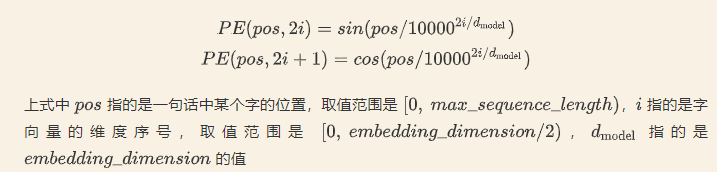

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Pad Mask
标记 P
由于在 Encoder 和 Decoder 中都需要进行 mask 操作，因此就无法确定这个函数的参数中 seq_len 的值，如果是在 Encoder 中调用的，seq_len 就等于 src_len；如果是在 Decoder 中调用的，seq_len 就有可能等于 src_len，也有可能等于 tgt_len（因为 Decoder 有两次 mask）

In [5]:
def get_attn_pad_mask(seq_q, seq_k):
    '''
    seq_q: [batch_size, seq_len]
    seq_k: [batch_size, seq_len]
    seq_len could be src_len or it could be tgt_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    '''
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # [batch_size, 1, len_k], False is masked
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # [batch_size, len_q, len_k]

# Subsequence Mask
Subsequence Mask 只有 Decoder 会用到，主要作用是屏蔽未来时刻单词的信息。

In [6]:
def get_attn_subsequence_mask(seq):
    '''
    seq: [batch_size, tgt_len]
    '''
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1) # Upper triangular matrix
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    return subsequence_mask # [batch_size, tgt_len, tgt_len]

# ScaledDotProductAttention
这里要做的是，通过 Q 和 K 计算出 scores，然后将 scores 和 V 相乘，得到每个单词的 context vector

In [7]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
        
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
        return context, attn

# MultiHeadAttention

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]

        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context) # [batch_size, len_q, d_model]
        return nn.LayerNorm(d_model).cuda()(output + residual), attn

# FeedForward Layer
这段代码非常简单，就是做两次线性变换，残差连接后再跟一个 Layer Norm

In [9]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).cuda()(output + residual) # [batch_size, seq_len, d_model]

# Encoder Layer

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn

# Encoder

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        '''
        enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
        enc_self_attns = []
        for layer in self.layers:
            # enc_outputs: [batch_size, src_len, d_model], enc_self_attn: [batch_size, n_heads, src_len, src_len]
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

# Decoder Layer

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask: [batch_size, tgt_len, src_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        # dec_outputs: [batch_size, tgt_len, d_model], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn, dec_enc_attn

# Decoder

In [13]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        enc_intpus: [batch_size, src_len]
        enc_outputs: [batsh_size, src_len, d_model]
        '''
        dec_outputs = self.tgt_emb(dec_inputs) # [batch_size, tgt_len, d_model]
        dec_outputs = self.pos_emb(dec_outputs.transpose(0, 1)).transpose(0, 1).cuda() # [batch_size, tgt_len, d_model]
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).cuda() # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs).cuda() # [batch_size, tgt_len, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0).cuda() # [batch_size, tgt_len, tgt_len]

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs) # [batc_size, tgt_len, src_len]

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

# Transformer

In [14]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder().cuda()
        self.decoder = Decoder().cuda()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False).cuda()
    def forward(self, enc_inputs, dec_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        dec_inputs: [batch_size, tgt_len]
        '''
        # tensor to store decoder outputs
        # outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        
        # enc_outputs: [batch_size, src_len, d_model], enc_self_attns: [n_layers, batch_size, n_heads, src_len, src_len]
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        # dec_outpus: [batch_size, tgt_len, d_model], dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [n_layers, batch_size, tgt_len, src_len]
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

# 模型 & 损失函数 & 优化器

In [15]:
model = Transformer().cuda()
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

# 训练

In [16]:
for epoch in range(30):
    for enc_inputs, dec_inputs, dec_outputs in loader:
      '''
      enc_inputs: [batch_size, src_len]
      dec_inputs: [batch_size, tgt_len]
      dec_outputs: [batch_size, tgt_len]
      '''
      enc_inputs, dec_inputs, dec_outputs = enc_inputs.cuda(), dec_inputs.cuda(), dec_outputs.cuda()
      # outputs: [batch_size * tgt_len, tgt_vocab_size]
      outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
      loss = criterion(outputs, dec_outputs.view(-1))
      print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

Epoch: 0001 loss = 2.335771
Epoch: 0002 loss = 2.236583
Epoch: 0003 loss = 2.008541
Epoch: 0004 loss = 1.784398
Epoch: 0005 loss = 1.568241
Epoch: 0006 loss = 1.309107
Epoch: 0007 loss = 1.148770
Epoch: 0008 loss = 0.850334
Epoch: 0009 loss = 0.716382
Epoch: 0010 loss = 0.575046
Epoch: 0011 loss = 0.460699
Epoch: 0012 loss = 0.355152
Epoch: 0013 loss = 0.249852
Epoch: 0014 loss = 0.214283
Epoch: 0015 loss = 0.154900
Epoch: 0016 loss = 0.124401
Epoch: 0017 loss = 0.132505
Epoch: 0018 loss = 0.139853
Epoch: 0019 loss = 0.094958
Epoch: 0020 loss = 0.134554
Epoch: 0021 loss = 0.071697
Epoch: 0022 loss = 0.056913
Epoch: 0023 loss = 0.056880
Epoch: 0024 loss = 0.041553
Epoch: 0025 loss = 0.054388
Epoch: 0026 loss = 0.048840
Epoch: 0027 loss = 0.064694
Epoch: 0028 loss = 0.068073
Epoch: 0029 loss = 0.047241
Epoch: 0030 loss = 0.044382


# 测试

In [17]:
def greedy_decoder(model, enc_input, start_symbol):
    """
    For simplicity, a Greedy Decoder is Beam search when K=1. This is necessary for inference as we don't know the
    target sequence input. Therefore we try to generate the target input word by word, then feed it into the transformer.
    Starting Reference: http://nlp.seas.harvard.edu/2018/04/03/attention.html#greedy-decoding
    :param model: Transformer Model
    :param enc_input: The encoder input
    :param start_symbol: The start symbol. In this example it is 'S' which corresponds to index 4
    :return: The target input
    """
    enc_outputs, enc_self_attns = model.encoder(enc_input)
    dec_input = torch.zeros(1, tgt_len).type_as(enc_input.data)
    next_symbol = start_symbol
    for i in range(0, tgt_len):
        dec_input[0][i] = next_symbol
        dec_outputs, _, _ = model.decoder(dec_input, enc_input, enc_outputs)
        projected = model.projection(dec_outputs)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[i]
        next_symbol = next_word.item()
    return dec_input

# Test
enc_inputs, _, _ = next(iter(loader))
greedy_dec_input = greedy_decoder(model, enc_inputs[0].view(1, -1).cuda(), start_symbol=tgt_vocab["S"])
predict, _, _, _ = model(enc_inputs[0].view(1, -1).cuda(), greedy_dec_input)
predict = predict.data.max(1, keepdim=True)[1]
print(enc_inputs[0], '->', [idx2word[n.item()] for n in predict.squeeze()])

tensor([1, 2, 3, 5, 0]) -> ['i', 'want', 'a', 'coke', '.', 'E']
